In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fca6208f-8307-7046-66c2-6f1b2c047c73)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# starting with the PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# checking all the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocessing the data

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

# How we want our data to look
```
[
  {'line_number': 0,
    'target': 'BACKGROUND'
    'text': "Emotional eating is associated with overeating and the development of obesity .\n"
    'total_lines': 11,
    ...}
]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 793 ms, sys: 135 ms, total: 928 ms
Wall time: 1.09 s


(180040, 30212, 30135)

In [ ]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

# Visualising our data with pandas

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# distribution of labels
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

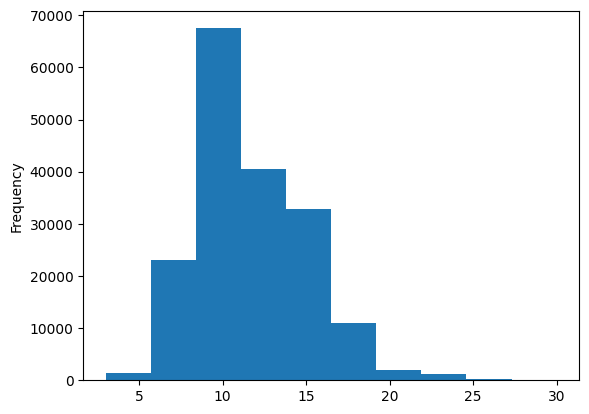

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
# get lists of sentences
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

## Target labels to numbers

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # if true return a sparse matrix else array

In [ ]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf

tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## Label encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0 (Baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model score is {baseline_score*100:.2f}%")

Our baseline model score is 72.18%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

## Function to calculate results

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)*100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(val_labels_encoded ,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Text vectorization layer

In [ ]:
import numpy as np

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

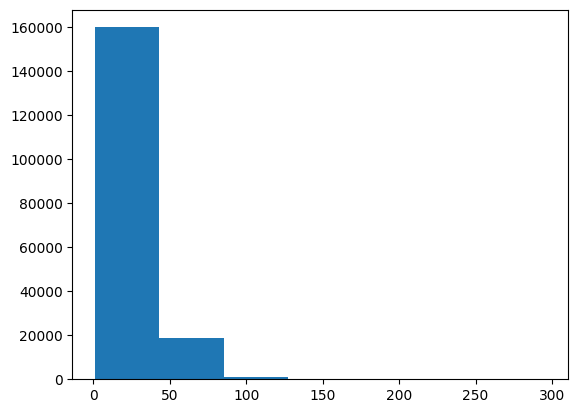

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

## Creating the text vectorizer

In [ ]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)

print(f"Text:\n{target_sentence}")
print(f"Length of text:\n{len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")


Text:
implant costs were @ % of initial hospitalization costs .
Length of text:
10

Vectorized text:
[[1517  577    9    4  473  843  577    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# how many words in our training vocab

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Most common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Most common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Creating a token embedding layer

In [ ]:
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab),#length of vocab
                                        output_dim=128,
                                        mask_zero=True,
                                        name="token_embedding")


In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
implant costs were @ % of initial hospitalization costs .

Sentence after vectorization (before embedding):
[[1517  577    9    4  473  843  577    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.03842409 -0.02975982 -0.02932702 ...  0.03394835 -0.03683349
   -0.02955512]
  [-0.03768674  0.03593886 -0.04171482 ... -0.00396155 -0.02907571
   -0.03668419]
  [ 0.00717949  0.03172406  0.02992215 ...  0.01460863  0.02373519
   -0.0475709 ]
  ...
  [-0.04551934  0.02602321 -0.01394868 ... -0.03023794  0.00550389
    0.02997062]
  [-0.04551934  0.02602321 -0.01394868 ... -0.03023794  0.00550389
    0.02997062]
  [-0.04551934  0.02602321 -0.01394868 ... -0.03023794  0.00550389
    0.02997062]]]

Embedded sentence shape: (1, 55, 128)


# Creating datasets(as fast as possible)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# TensorSliceDataset converting to prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model-1 (Conv1D)

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs, name="model_1_conv1D")

model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 21s 33ms/step - loss: 0.9199 - accuracy: 0.6380 - val_loss: 0.6909 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6607 - accuracy: 0.7546 - val_loss: 0.6345 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6159 - accuracy: 0.7761 - val_loss: 0.5963 - val_accuracy: 0.7859


In [ ]:
model_1.evaluate(valid_dataset)


945/945 [==============================] - 4s 4ms/step - loss: 0.5969 - accuracy: 0.7881


[0.5969167947769165, 0.7880974411964417]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.7678253e-01, 1.5140826e-01, 5.0389037e-02, 3.0217141e-01,
        1.9248687e-02],
       [3.9293879e-01, 3.0382746e-01, 1.2106692e-02, 2.8209507e-01,
        9.0319654e-03],
       [1.5591168e-01, 7.2839269e-03, 2.1826038e-03, 8.3458930e-01,
        3.2419426e-05],
       ...,
       [1.0008975e-05, 8.1598107e-04, 1.0182167e-03, 4.8235825e-06,
        9.9815089e-01],
       [4.4962808e-02, 4.7277087e-01, 8.0044605e-02, 5.7850856e-02,
        3.4437093e-01],
       [1.6994941e-01, 6.9417936e-01, 4.5385621e-02, 4.7686819e-02,
        4.2798772e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.80974447239507,
 'precision': 0.7850363583625222,
 'recall': 0.7880974447239507,
 'f1': 0.7856801315289836}

##Model 2: Feature extraction with pretrained token embeddings


In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
in the highest baseline bmi group , the mean increase in triglycerides was @ and @ % in the atv/r and lpv/r arms , respectively .

Sentence after embedding:
[-0.00971456  0.01037106 -0.0104351  -0.0273001  -0.02249291 -0.01510036
 -0.03056139 -0.05113742 -0.05349253  0.04678805  0.0636134   0.01874467
 -0.06427366 -0.02573305 -0.06443615 -0.00749563 -0.08574142 -0.00611815
 -0.01280435  0.04823345  0.03451956  0.00217599 -0.01295516 -0.04995313
  0.02335102  0.04106525  0.01063864  0.02472979  0.02218883 -0.06373401] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = tf.keras.layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9177 - accuracy: 0.6492 - val_loss: 0.7973 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7702 - accuracy: 0.7013 - val_loss: 0.7567 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7554 - accuracy: 0.7092 - val_loss: 0.7424 - val_accuracy: 0.7124


In [ ]:
model_2.evaluate(valid_dataset)


945/945 [==============================] - 11s 12ms/step - loss: 0.7443 - accuracy: 0.7113


[0.7442595362663269, 0.7113067507743835]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[0.43948236, 0.3484731 , 0.00257211, 0.20166351, 0.00780899],
       [0.30325502, 0.54680204, 0.00290063, 0.14422889, 0.00281338],
       [0.20376584, 0.13518001, 0.02208353, 0.6028599 , 0.03611076],
       ...,
       [0.00145318, 0.00738455, 0.06176007, 0.00100198, 0.9284003 ],
       [0.0032596 , 0.04264791, 0.19876996, 0.00161637, 0.75370616],
       [0.15202355, 0.22785135, 0.54657817, 0.0079795 , 0.06556752]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.1306765523633,
 'precision': 0.711305286242712,
 'recall': 0.711306765523633,
 'f1': 0.7081875393244097}

# Model 3: Conv1D with character embeddings

## Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'i n   t h e   h i g h e s t   b a s e l i n e   b m i   g r o u p   ,   t h e   m e a n   i n c r e a s e   i n   t r i g l y c e r i d e s   w a s   @   a n d   @   %   i n   t h e   a t v / r   a n d   l p v / r   a r m s   ,   r e s p e c t i v e l y   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# avg character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

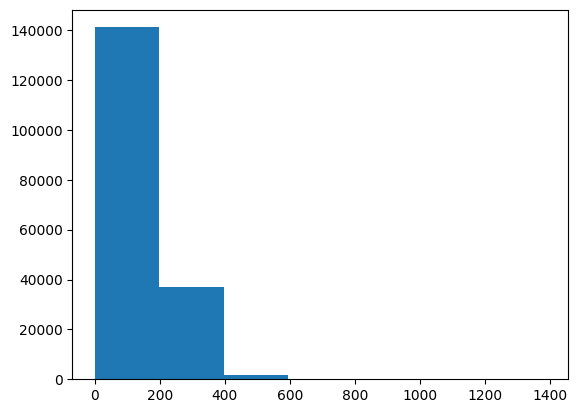

In [ ]:
# check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# creating char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    # standardize=None, # set none if we want to include punctuation
                                    name="char_vectorizer")

In [ ]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# check vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n   t h i s   m u l t i c e n t r e   ,   r a n d o m i s e d   ,   d o u b l e - m a s k e d   ,   p l a c e b o - c o n t r o l l e d   t r i a l   ,   w e   e n r o l l e d   c o r t i c o s t e r o i d   u n r e s p o n s i v e   a d u l t   p a t i e n t s   (   a g e d   @   y e a r s   )   w i t h   p r i m a r y   i m m u n e   t h r o m b o c y t o p e n i a   a n d   a   p l a t e l e t   c o u n t   o f   l e s s   t h a n   @   (   @   )   p l a t e l e t s   p e r   l .   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   (   @ : @   )   t o   f o u r   w e e k l y   i n f u s i o n s   o f   @   m g / m   (   @   )   r i t u x i m a b   o r   p l a c e b o   .

Length of chars: 289

Vectorized chars:
[[ 4  6  3 13  4  9 15 16 12  3  4 11  2  6  3  8  2  8  5  6 10  7 15  4
   9  2 10 10  7 16 22 12  2 15  5  9 23  2 10 14 12  5 11  2 22  7 11  7
   6  3  8  7 12 12  2 10  3  8  4  5 12 20  2  2  6  8  7 12 12  2 10 11
   7  8  3  4 11  7  9 

## Creating an character-level embedding layer

In [ ]:
char_embed = tf.keras.layers.Embedding(input_dim= NUM_CHAR_TOKENS,
                                       output_dim= 25,
                                       mask_zero=False,
                                       name="char_embed")

print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n   t h i s   m u l t i c e n t r e   ,   r a n d o m i s e d   ,   d o u b l e - m a s k e d   ,   p l a c e b o - c o n t r o l l e d   t r i a l   ,   w e   e n r o l l e d   c o r t i c o s t e r o i d   u n r e s p o n s i v e   a d u l t   p a t i e n t s   (   a g e d   @   y e a r s   )   w i t h   p r i m a r y   i m m u n e   t h r o m b o c y t o p e n i a   a n d   a   p l a t e l e t   c o u n t   o f   l e s s   t h a n   @   (   @   )   p l a t e l e t s   p e r   l .   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   (   @ : @   )   t o   f o u r   w e e k l y   i n f u s i o n s   o f   @   m g / m   (   @   )   r i t u x i m a b   o r   p l a c e b o   .

Embedded chars (after vectorization and embedding):
[[[ 0.01734987  0.04088182  0.03298097 ... -0.03720428 -0.02333094
   -0.0351436 ]
  [-0.01253979 -0.00867556  0.04898559 ...  0.00443391  0.04133997
   -0.02626204]
  [ 0.01277477  0.01247247  0.

## Model 3 (Conv1D)

In [ ]:
# make Conv1D on chars only
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# creating char_level_datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.4605 - accuracy: 0.3453 - val_loss: 1.4105 - val_accuracy: 0.3976
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3742 - accuracy: 0.4141 - val_loss: 1.3427 - val_accuracy: 0.4405
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3332 - accuracy: 0.4480 - val_loss: 1.3163 - val_accuracy: 0.4471


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 1.3161 - accuracy: 0.4481


[1.3160841464996338, 0.4481332004070282]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.1676105 , 0.2496262 , 0.25604883, 0.18530549, 0.14140901],
       [0.11392321, 0.16502018, 0.16016495, 0.06585773, 0.49503392],
       [0.10147274, 0.16171625, 0.41223532, 0.10716747, 0.21740822],
       ...,
       [0.07665232, 0.11550133, 0.24905907, 0.04734882, 0.5114385 ],
       [0.05768117, 0.10047982, 0.2412954 , 0.0444183 , 0.5561253 ],
       [0.142175  , 0.17853574, 0.21677431, 0.07356828, 0.38894662]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.813319210909576,
 'precision': 0.3765038613993536,
 'recall': 0.44813319210909575,
 'f1': 0.3942968004834402}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)


1.   Create a token-level model (similar to model_1)
2.   Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3.   Combine (using layers.Concatenate) the outputs of 1 and 2
4.   Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of *Neural Networks for Joint Sentence Classification*









In [ ]:
# 1. Creating token inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_string")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Creating character inputs/model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Combining the layers using layers.Concatenate
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                           char_model.output])

# 4. Create output layer
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct the model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")




In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_string (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

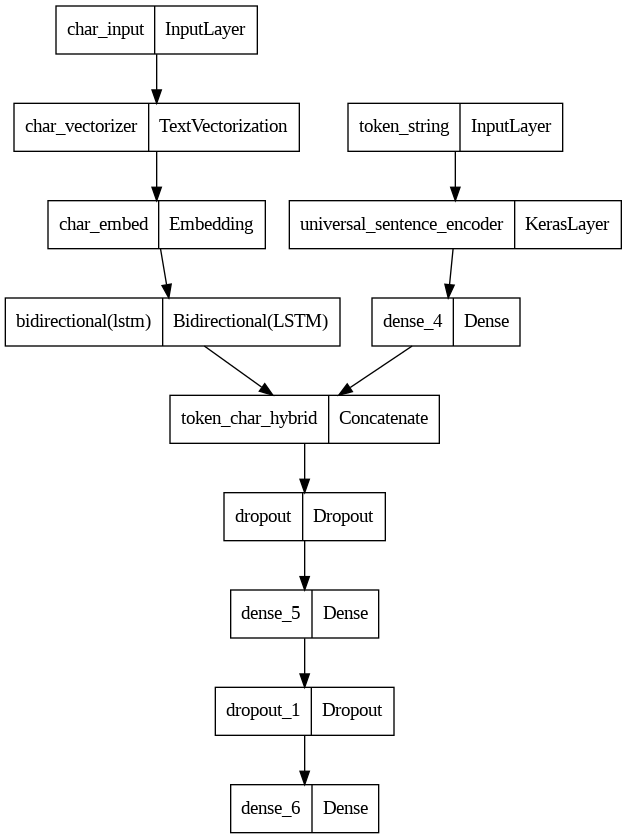

In [ ]:
tf.keras.utils.plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Combining token and character data into a tf.data dataset
The difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

((token_data, char_data), (label))

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                               validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 42ms/step - loss: 0.9719 - accuracy: 0.6115 - val_loss: 0.8049 - val_accuracy: 0.6935
Epoch 2/3
562/562 [==============================] - 19s 35ms/step - loss: 0.8060 - accuracy: 0.6888 - val_loss: 0.7251 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.7769 - accuracy: 0.7021 - val_loss: 0.6933 - val_accuracy: 0.7384


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6980 - accuracy: 0.7308


[0.6979666352272034, 0.7308354377746582]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 20s 20ms/step


{'accuracy': 73.08354296306103,
 'precision': 0.7289075066892654,
 'recall': 0.7308354296306103,
 'f1': 0.7276069458682359}

# Positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Adding the line number feature

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

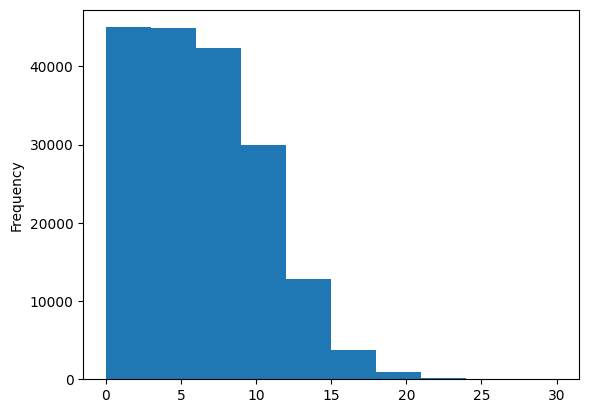

In [ ]:
train_df["line_number"].plot.hist()

In [ ]:
# using tensorflow to create one-hot encoder
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_df["total_lines"].value_counts()


11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

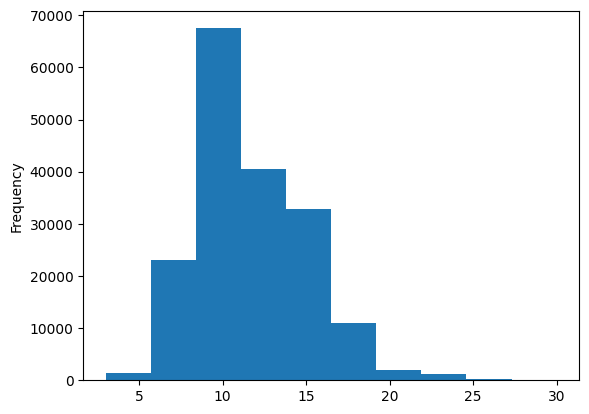

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## Building a tribrid embedding model

1. Create a token-level mode
2. Create a character-level mode
3. Create a model for "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine outputs of 3 & 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept tribried embedding and output label probablities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Character inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = tf.keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)



model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

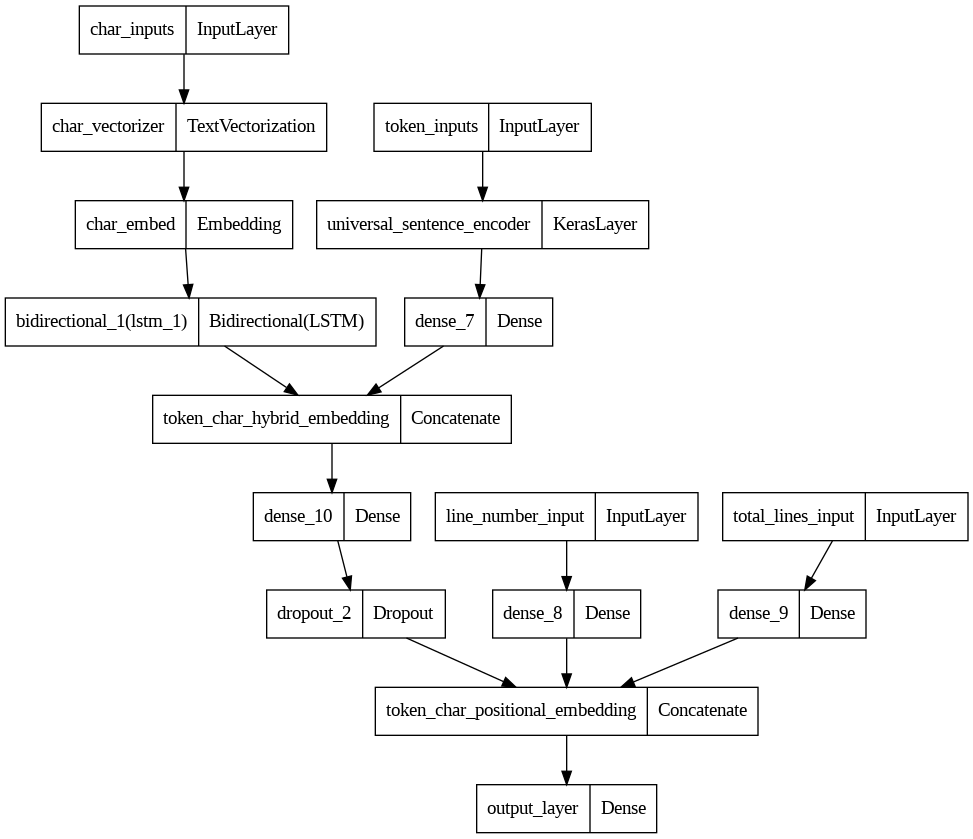

In [ ]:
tf.keras.utils.plot_model(model_5)

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79427dc78940> True
<keras.src.engine.input_layer.InputLayer object at 0x79427db3f460> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7941e4e2f5e0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7942882311b0> False
<keras.src.layers.core.embedding.Embedding object at 0x7941e4e65b70> True
<keras.src.layers.core.dense.Dense object at 0x79427dce3e80> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x79427dcbc250> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x79427db5b490> True
<keras.src.engine.input_layer.InputLayer object at 0x79427dce0640> True
<keras.src.engine.input_layer.InputLayer object at 0x79427db5a2c0> True
<keras.src.layers.core.dense.Dense object at 0x79427da62440> True
<keras.src.layers.core.dense.Dense object at 0x7941dacf91e0> True
<keras.src.layers.core.dense.Dense object at 0x79427db075b0> True
<keras.src.layers.regularization.dropout.

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create tribrid embedding datasets and fit tribrid model


In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 28s 39ms/step - loss: 1.0961 - accuracy: 0.7233 - val_loss: 0.9804 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.9672 - accuracy: 0.8150 - val_loss: 0.9495 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9513 - accuracy: 0.8227 - val_loss: 0.9389 - val_accuracy: 0.8324


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose =1)

945/945 [==============================] - 20s 20ms/step


In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 83.15238977889581,
 'precision': 0.8300042166207565,
 'recall': 0.8315238977889581,
 'f1': 0.8304523686080151}

# Comparing model results

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.809744,0.785036,0.788097,0.785680
pretrained_token_embed,71.130677,0.711305,0.711307,0.708188
custom_char_embed_conv1d,44.813319,0.376504,0.448133,0.394297
hybrid_char_token_embed,73.083543,0.728908,0.730835,0.727607
tribrid_pos_char_token_embed,83.152390,0.830004,0.831524,0.830452


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

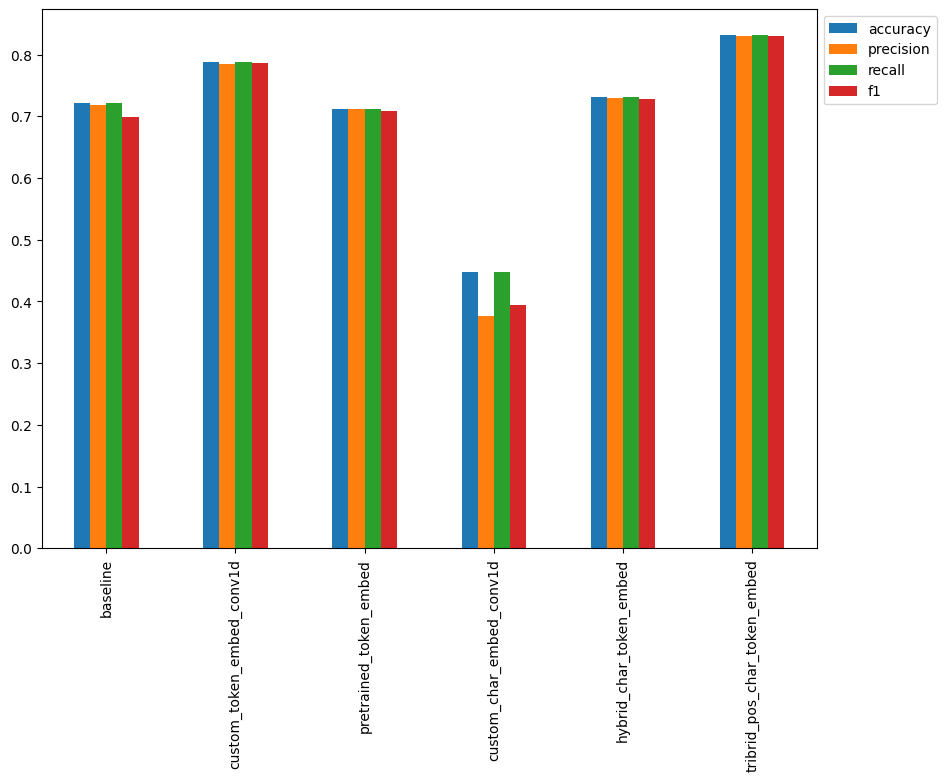

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


<Axes: >

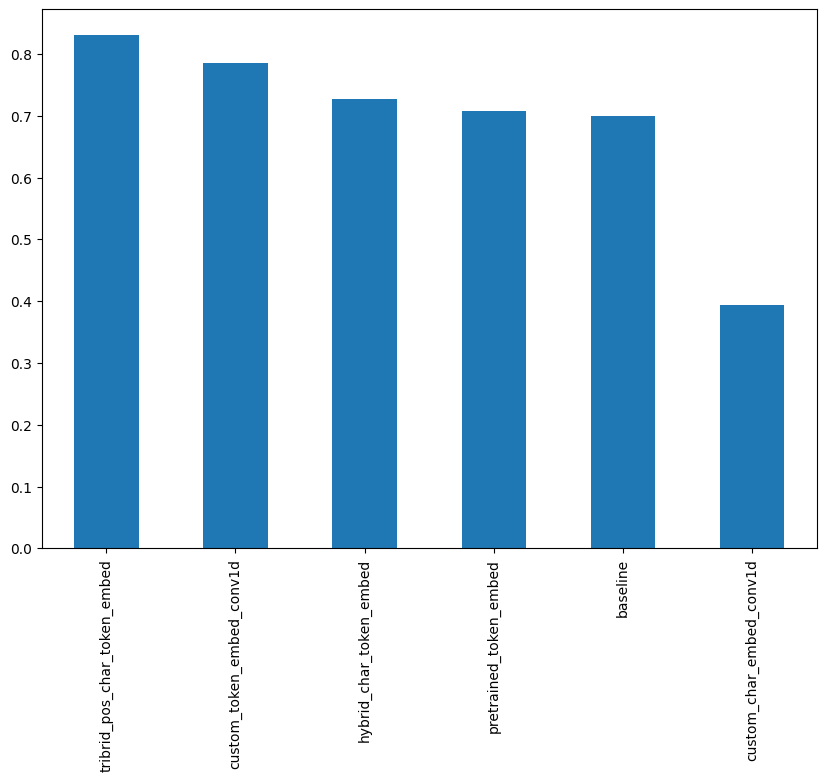

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [ ]:
model_5.save("skimlit_tribrid_model_10percent_20k_pubmed20k_rct")

In [ ]:
!zip -r /content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct.zip /content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct

updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/ (stored 0%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/variables/ (stored 0%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/variables/variables.index (deflated 77%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/assets/ (stored 0%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/fingerprint.pb (stored 0%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/saved_model.pb (deflated 72%)
updating: content/skimlit_tribrid_model_10percent_20k_pubmed20k_rct/keras_metadata.pb (deflated 91%)


In [ ]:
# model_5.save("skimlit_tribrid_model_10percent_20k_pubmed20k_rct.hdf5")
model_5.save("skimlit_tribrid_model_10percent_20k_pubmed20k_rct", save_format='tf')

In [ ]:
model_5.save("skimlit_tribrid_model_10percent_20k_pubmed20k_rct.keras")

# Loading the saved model

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model_10percent_20k_pubmed20k_rct")

In [ ]:
loaded_model.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 20s 20ms/step - loss: 0.9369 - accuracy: 0.8315


[0.936908483505249, 0.8315238952636719]

## Find most wrong

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 19s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 82.7775012444002,
 'precision': 0.8261845034974992,
 'recall': 0.827775012444002,
 'f1': 0.8267394837462051}

## Getting the most wrong

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

CPU times: user 15.1 s, sys: 788 ms, total: 15.9 s
Wall time: 15 s


In [ ]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"]

In [ ]:
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.489885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.363657,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.805599,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.580617,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.736250,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.879160,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.557308,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.479922,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.459729,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.576643,True


In [ ]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.953189,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.942299,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.934650,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.925465,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.923894,False
...,...,...,...,...,...,...,...
23592,BACKGROUND,"we recorded the number of dead ducklings , gro...",4,12,METHODS,0.843512,False
12304,BACKGROUND,"the severity of psychiatric symptoms , as meas...",2,16,METHODS,0.843202,False
2575,CONCLUSIONS,clinicaltrials.gov : nct@ .,10,10,BACKGROUND,0.843010,False
1220,RESULTS,the group intervention consisted of @ weekly c...,2,13,METHODS,0.842704,False


In [ ]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9531888365745544, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9422993659973145, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9346501231193542, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9254651665687561, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9238936901092529, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk 

## Make example predictions



In [ ]:
import json

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json



--2024-01-04 06:49:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-01-04 06:49:34 (92.6 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



In [ ]:
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts


[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:

# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 1.66 s, sys: 15.8 ms, total: 1.67 s
Wall time: 1.71 s


array([[0.26823732, 0.09101655, 0.01682123, 0.5934786 , 0.03044627],
       [0.06494986, 0.02460679, 0.76638836, 0.08508575, 0.05896924],
       [0.12331747, 0.0566563 , 0.54746395, 0.18812805, 0.08443418],
       [0.10273596, 0.13145894, 0.5140466 , 0.08428603, 0.16747247],
       [0.05352934, 0.10930076, 0.48644873, 0.0465278 , 0.30419332],
       [0.02997833, 0.11883163, 0.55795974, 0.04052654, 0.25270373],
       [0.02849626, 0.12828703, 0.06387581, 0.02398072, 0.7553602 ],
       [0.01986041, 0.13917887, 0.27850503, 0.03192266, 0.530533  ]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


# Model - 6 (Training on the 100% 20k pubmedrct data)

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Character inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = tf.keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)



model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

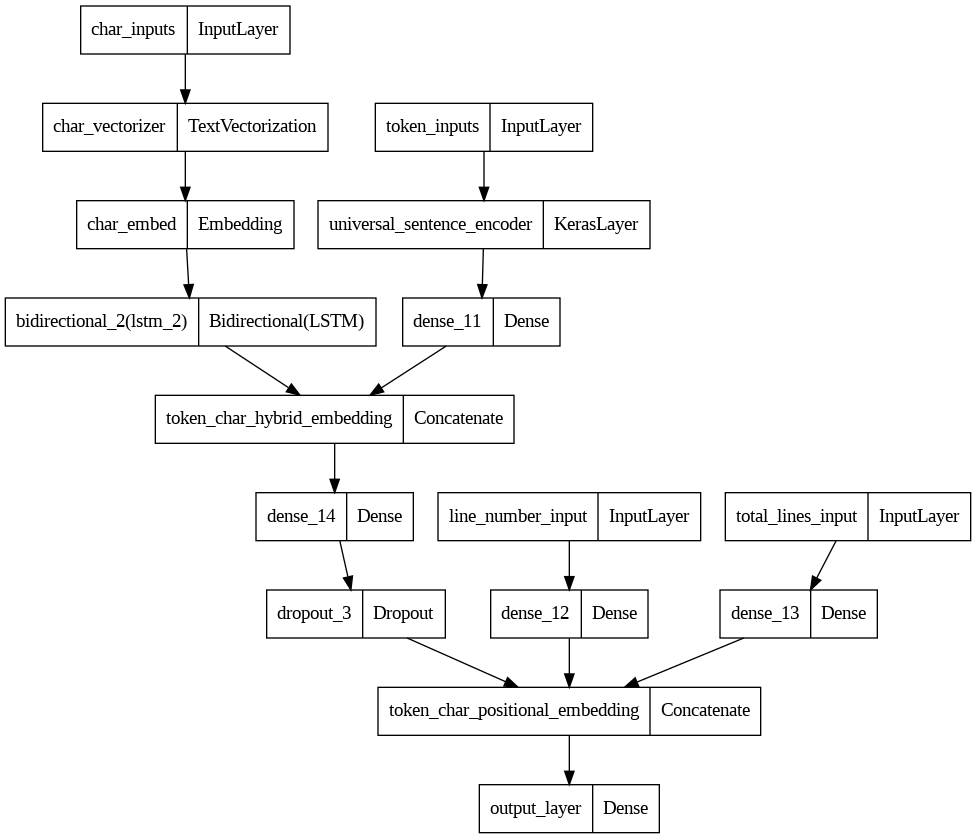

In [ ]:
tf.keras.utils.plot_model(model_6)

In [ ]:
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Creating model callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience = 3)
checkpoint_path = "ckpt/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor="val_loss")

In [147]:
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(len(train_pos_char_token_dataset)),
                              epochs=100,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(len(val_pos_char_token_dataset)),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
5627/5627 [==============================] - 223s 40ms/step - loss: 0.4176 - accuracy: 0.8174 - val_loss: 0.4051 - val_accuracy: 0.8397
Epoch 2/100
5627/5627 [==============================] - 229s 41ms/step - loss: 0.4058 - accuracy: 0.8439 - val_loss: 0.4029 - val_accuracy: 0.8433
Epoch 3/100
5627/5627 [==============================] - 221s 39ms/step - loss: 0.4019 - accuracy: 0.8536 - val_loss: 0.4016 - val_accuracy: 0.8462
Epoch 4/100
5627/5627 [==============================] - 236s 42ms/step - loss: 0.3993 - accuracy: 0.8604 - val_loss: 0.4012 - val_accuracy: 0.8454
Epoch 5/100
5627/5627 [==============================] - 199s 35ms/step - loss: 0.3971 - accuracy: 0.8659 - val_loss: 0.4014 - val_accuracy: 0.8447
Epoch 6/100
5627/5627 [==============================] - 199s 35ms/step - loss: 0.3954 - accuracy: 0.8698 - val_loss: 0.4021 - val_accuracy: 0.8442
Epoch 7/100
5627/5627 [==============================] - 191s 34ms/step - loss: 0.3939 - accuracy: 0.8741 - val_